In [1]:
import pandas as pd
import io
import re
import csv
import json
import numpy as np
from numpy import savetxt, loadtxt, asarray
from tqdm import tqdm
import math
import ast
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import seaborn as sns
import keras
from keras import backend as K
from progressbar import ProgressBar
import matplotlib.pyplot as plt
from keras import Sequential, Model
from random import randrange
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from keras.utils.vis_utils import plot_model
import time
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance


from plot_figures import save_model

pbar = ProgressBar()
tqdm.pandas()

Using TensorFlow backend.


In [2]:


max_blocks = 37 #(36 + 1 FC layer at the end)
#max_blocks = 36

nb_param =7
#nb_param =13
nb_hw_param = 12
#nb_param =12

inversed = True
only_inversed = False

if inversed and not only_inversed:
    path_entire_model= "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/with_inversed_hw"
elif only_inversed:
    path_entire_model= "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/only_inversed_hw"
else : 
    path_entire_model= "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/no_inversed_hw"

BATCH_SIZE = 2048
SHUFFLE_BUFFER_SIZE = 100

DATASET_SIZE = 168308
train_size = int(0.90 * DATASET_SIZE) #135 805
test_size = int(0.10 * DATASET_SIZE) # 15 089

nb_training_batches = train_size //BATCH_SIZE +1
nb_test_batches = test_size //BATCH_SIZE +1

In [3]:

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.asarray(ast.literal_eval(array_string))

# Load Proccessed Neural Networks (without HyperParameters)

In [4]:

#%pycache
path_raw_val = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/parsed_nondups_val_2.csv'
path_raw_train = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/parsed_nondups_train_2.csv'

#path_processed_val_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/val_13.csv'
#path_processed_train_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/train_13.csv'


path_processed_val_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/val_7_new.csv'
path_processed_train_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/train_7_new.csv'



#



# Power < 200

In [5]:
%pycache
path_raw_val = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/lower_power/parsed_nondups_val_lower_power.csv'
path_raw_train = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/lower_power/parsed_nondups_train_lower_power.csv'

path_processed_val_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/lower_power/val_low_power.csv'
path_processed_train_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/lower_power/train_low_power.csv'

UsageError: Line magic function `%pycache` not found.


In [6]:
#%pycache
tin= time.clock()

    
val = pd.read_csv(path_processed_val_nn,converters={'NN_dataframe': from_np_array})
train = pd.read_csv(path_processed_train_nn,converters={'NN_dataframe': from_np_array})

tfin= time.clock()
print(f'Total time : {(tfin-tin)/60} min')

Total time : 1.2351907500000001 min


# Complete to zeros (max shape)

In [7]:
def add_zero_blocks(arr):
    zero_blocks = np.zeros((max_blocks-arr.shape[0],arr.shape[1]))
    return np.append(arr, zero_blocks, axis=0)

val['NN_dataframe']= val['NN_dataframe'].apply(lambda x : add_zero_blocks(x))
train['NN_dataframe']= train['NN_dataframe'].apply(lambda x : add_zero_blocks(x))



# Get y_train, y_val


In [8]:
# To retrieve y_train / y_test

train_hw = pd.read_csv(path_raw_train)
val_hw = pd.read_csv(path_raw_val)

y_train = np.array(train_hw["total_power"].tolist())
y_train=y_train.reshape(y_train.shape[0],-1)

y_val = np.array(val_hw["total_power"].tolist())
y_val=y_val.reshape(y_val.shape[0],-1)

In [9]:
train_hw.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,G,C,B,J,name,bw_power,core_power,total_power
0,118.0,2.0,256.0,179968.0,2048.0,3.636011e+06,18770712.0,19987780.0,0.000533,0.0,79.951120,21.330414,101.281534
1,87.0,2.0,512.0,99968.0,2048.0,2.325259e+06,14362735.0,21849702.0,0.000570,0.0,87.398808,22.816285,110.215093
2,124.0,2.0,512.0,99968.0,3072.0,2.533459e+06,12739050.0,21849702.0,0.000543,0.0,87.398808,21.716202,109.115010
3,80.0,2.0,1024.0,99968.0,1024.0,2.327509e+06,12155422.0,21849702.0,0.000684,0.0,87.398808,27.343500,114.742308
4,86.0,2.0,512.0,60000.0,1536.0,1.728057e+06,16407889.0,28402776.0,0.000604,0.0,113.611104,24.174307,137.785411


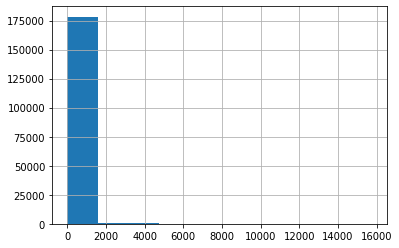

In [10]:
train_hw["total_power"].hist()

In [11]:
len(train_hw)

180035

In [12]:
len(train_hw["total_power"].unique())

163588

In [13]:
%pycache
for i in range(len(X_train_hw_param)):

    if type(X_train_hw_param['mac_num'][i]) != float64 :
        print (type(X_train_hw_param['mac_num'][i]))
        print(i)
        break

UsageError: Line magic function `%pycache` not found.


--------
# HW PARAM ALONE

In [14]:
X_train_hw_param  = train_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
X_train_hw_param['tot_mac'] = X_train_hw_param['mac_num']*X_train_hw_param['mac_array_num']

X_val_hw_param  = val_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
X_val_hw_param['tot_mac'] = X_val_hw_param['mac_num']*X_val_hw_param['mac_array_num']

X_train_hw_param.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,tot_mac
0,118.0,2.0,256.0,179968.0,2048.0,236.0
1,87.0,2.0,512.0,99968.0,2048.0,174.0
2,124.0,2.0,512.0,99968.0,3072.0,248.0
3,80.0,2.0,1024.0,99968.0,1024.0,160.0
4,86.0,2.0,512.0,60000.0,1536.0,172.0


# Inv

In [15]:
def inv(x):
    return 1/(1+x)


if inversed : 
#nb_hw_param = 6
    nb_hw_param = 12
    X_train_hw_param['1/mac_num'] = X_train_hw_param['mac_num'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/mac_array_num'] = X_train_hw_param['mac_array_num'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/data_bits'] = X_train_hw_param['data_bits'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/sram_size'] = X_train_hw_param['sram_size'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/max_filter_size'] = X_train_hw_param['max_filter_size'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/tot_mac'] = X_train_hw_param['tot_mac'].progress_apply(lambda x : inv(x))


    X_val_hw_param['1/mac_num'] = X_val_hw_param['mac_num'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/mac_array_num'] = X_val_hw_param['mac_array_num'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/data_bits'] = X_val_hw_param['data_bits'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/sram_size'] = X_val_hw_param['sram_size'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/max_filter_size'] = X_val_hw_param['max_filter_size'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/tot_mac'] = X_val_hw_param['tot_mac'].progress_apply(lambda x : inv(x))

if only_inversed : 
    nb_hw_param = 6
    inv = ['1/mac_num','1/mac_array_num','1/data_bits','1/sram_size','1/max_filter_size','1/tot_mac']
    X_train_hw_param =X_train_hw_param.loc[:, inv]
    X_val_hw_param =X_val_hw_param.loc[:, inv]


100%|██████████| 19823/19823 [00:00<00:00, 562051.31it/s]


In [16]:
X_val_hw_param.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,tot_mac,1/mac_num,1/mac_array_num,1/data_bits,1/sram_size,1/max_filter_size,1/tot_mac
0,37.0,2.0,128.0,199936.0,4098.0,74.0,0.026316,0.333333,0.007752,0.000005,0.000244,0.013333
1,91.0,2.0,256.0,119936.0,2048.0,182.0,0.010870,0.333333,0.003891,0.000008,0.000488,0.005464
2,74.0,2.0,256.0,139904.0,1024.0,148.0,0.013333,0.333333,0.003891,0.000007,0.000976,0.006711
3,70.0,2.0,512.0,80000.0,512.0,140.0,0.014085,0.333333,0.001949,0.000012,0.001949,0.007092
4,103.0,2.0,256.0,199936.0,4098.0,206.0,0.009615,0.333333,0.003891,0.000005,0.000244,0.004831


## HW Normalize

In [17]:
# normalize

#%pycache
# Process
scaler = preprocessing.StandardScaler().fit(X_train_hw_param)
X_train_hw_param_norm= scaler.transform(X_train_hw_param)
X_val_hw_param_norm = scaler.transform(X_val_hw_param )


In [18]:
pd.DataFrame(X_train_hw_param_norm).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.855258,-0.477343,-0.626804,0.579117,0.378413,-0.234344,-0.646343,0.682974,0.067871,-1.016970,-0.813434,-0.496671
1,0.290469,-0.477343,-0.236403,-0.349614,0.378413,-0.301483,-0.562039,0.682974,-0.598397,-0.091607,-0.813434,-0.398567
2,0.964571,-0.477343,-0.236403,-0.349614,1.254991,-0.221349,-0.657830,0.682974,-0.598397,-0.091607,-1.063253,-0.510016
3,0.162936,-0.477343,0.544398,-0.349614,-0.498166,-0.316643,-0.534072,0.682974,-0.932506,-0.091607,-0.064467,-0.365958
4,0.272250,-0.477343,-0.236403,-0.813608,-0.059876,-0.303648,-0.558319,0.682974,-0.598397,1.295065,-0.563698,-0.394232


In [19]:
pd.DataFrame(X_train_hw_param).head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,tot_mac,1/mac_num,1/mac_array_num,1/data_bits,1/sram_size,1/max_filter_size,1/tot_mac
0,118.0,2.0,256.0,179968.0,2048.0,236.0,0.008403,0.333333,0.003891,0.000006,0.000488,0.004219
1,87.0,2.0,512.0,99968.0,2048.0,174.0,0.011364,0.333333,0.001949,0.000010,0.000488,0.005714
2,124.0,2.0,512.0,99968.0,3072.0,248.0,0.008000,0.333333,0.001949,0.000010,0.000325,0.004016
3,80.0,2.0,1024.0,99968.0,1024.0,160.0,0.012346,0.333333,0.000976,0.000010,0.000976,0.006211
4,86.0,2.0,512.0,60000.0,1536.0,172.0,0.011494,0.333333,0.001949,0.000017,0.000651,0.005780


## Datasets for HW param

In [20]:

X_hw_norm = np.concatenate((X_train_hw_param_norm, X_val_hw_param_norm))
X_hw = np.concatenate((X_train_hw_param, X_val_hw_param))
y = np.concatenate((y_train, y_val))

# Mix train/test
#NORMED
dataset_hw_norm = tf.data.Dataset.from_tensor_slices((X_hw_norm, y))
dataset_hw_norm= dataset_hw_norm.shuffle(SHUFFLE_BUFFER_SIZE)
#UNORMED
dataset_hw = tf.data.Dataset.from_tensor_slices((X_hw, y))
#small_dataset_hw = dataset_hw.filter(lambda x, label: label<100)
dataset_hw= dataset_hw.shuffle(SHUFFLE_BUFFER_SIZE)

# Split them
#NORMED
train_dataset_hw_norm =  dataset_hw_norm.take(train_size).batch(BATCH_SIZE)
test_dataset_hw_norm = dataset_hw_norm.skip(train_size).batch(BATCH_SIZE)

#UNORMODED
train_dataset_hw =  dataset_hw.take(train_size).batch(BATCH_SIZE)
test_dataset_hw = dataset_hw.skip(train_size).batch(BATCH_SIZE)


------------

# NN TREATEMENT ALONE

In [21]:


X_train_nn =np.array(train['NN_dataframe'].tolist())
X_val_nn = np.array(val['NN_dataframe'].tolist())

## NN Normalize

### Divde columns by standard deviation

In [22]:


means = []
std = []
X_train_nn_norm=X_train_nn.copy()
X_val_nn_norm = X_val_nn.copy()
for i in range(nb_param):
    #means.append(np.mean(X_train_nn[:,:,i]))
    #X_train_nn[:,:,i]=-means[i]
    std.append(np.std(X_train_nn[:,:,i]))
    if std[i]!=0:
        X_train_nn[:,:,i]/= std[i]
        X_val_nn[:,:,i]/= std[i]  

#savetxt('std.csv', std, delimiter=',')
#data = loadtxt('std.csv', delimiter=',')

In [23]:
std

[282669167.2068437,
 474753.5435396601,
 135528.50830774553,
 137473.53306652652,
 310.4712383514654,
 12.199977367222479,
 0.39403139516178176]

In [24]:
len(X_train_nn_norm)

180035

### Bad normalisation

In [25]:
%pycache
# #Reshape
train_reshape= X_train_nn.reshape(X_train_nn.shape[0], -1)
val_reshape= X_val_nn.reshape(X_val_nn.shape[0], -1)

# # Process
scaler = preprocessing.StandardScaler().fit(train_reshape)
train_scaled= scaler.transform(train_reshape)
val_scaled = scaler.transform(val_reshape)


#Re-reshape
X_train_nn_norm= train_scaled.reshape(X_train_nn.shape)
X_val_nn_norm= val_scaled.reshape(X_val_nn.shape)

UsageError: Line magic function `%pycache` not found.


In [26]:
(std)


[282669167.2068437,
 474753.5435396601,
 135528.50830774553,
 137473.53306652652,
 310.4712383514654,
 12.199977367222479,
 0.39403139516178176]

In [27]:
pd.DataFrame(X_train_nn[-100]).head()

,0,1,2,3,4,5,6
0,0.023964,0.000590,1.110674,0.912467,0.009663,0.737706,0.000000
1,0.007988,0.000211,0.925562,0.912467,0.032209,0.737706,0.000000
2,0.023076,0.000602,0.925562,2.372413,0.032209,0.081967,0.000000
3,0.911503,0.022239,2.406460,2.554906,0.418718,2.049184,0.000000
4,1.007712,0.024535,2.591573,2.554906,0.450927,2.049184,2.537869


In [28]:
pd.DataFrame(X_train_nn_norm[-100]).head()

,0,1,2,3,4,5,6
0,6773760.0,280.0,150528.0,125440.0,3.0,9.0,0.0
1,2257920.0,100.0,125440.0,125440.0,10.0,9.0,0.0
2,6522880.0,286.0,125440.0,326144.0,10.0,1.0,0.0
3,257653760.0,10558.0,326144.0,351232.0,130.0,25.0,0.0
4,284849152.0,11648.0,351232.0,351232.0,140.0,25.0,1.0


## Datasets for NN

In [29]:

X_nn_norm = np.concatenate((X_train_nn_norm, X_val_nn_norm))
X_nn = np.concatenate((X_train_nn, X_val_nn))
y = np.concatenate((y_train, y_val))

# Mix test/train 
#NORMED
dataset_nn_norm = tf.data.Dataset.from_tensor_slices((X_nn_norm, y))
dataset_nn_norm= dataset_nn_norm.shuffle(SHUFFLE_BUFFER_SIZE)

#UNNORMED
dataset_nn = tf.data.Dataset.from_tensor_slices((X_nn, y))
dataset_nn.shuffle(SHUFFLE_BUFFER_SIZE)


# Split them
#NORMED
test_dataset_nn_norm = dataset_nn_norm.take(test_size).batch(BATCH_SIZE)
train_dataset_nn_norm = dataset_nn_norm.skip(test_size).batch(BATCH_SIZE)

#UNORMED
test_dataset_nn= dataset_nn.take(test_size).batch(BATCH_SIZE)
train_dataset_nn = dataset_nn.skip(test_size).batch(BATCH_SIZE)

In [30]:
X_train_nn_norm[0].shape

(37, 7)

In [31]:
len(y_train)

180035

In [32]:
len(X_train_nn_norm)

180035

# Full Dataset (HW_params + NN arrays)

In [33]:
#NORMED
train_dataset_norm = tf.data.Dataset.from_tensor_slices(((X_train_nn_norm, X_train_hw_param_norm), y_train))
test_dataset_norm = tf.data.Dataset.from_tensor_slices(((X_val_nn_norm, X_val_hw_param_norm), y_val))

#UNORMED
train_dataset = tf.data.Dataset.from_tensor_slices(((np.array(X_train_nn), np.array(X_train_hw_param)), y_train))
test_dataset = tf.data.Dataset.from_tensor_slices(((np.array(X_val_nn), np.array(X_val_hw_param)), y_val))


### Shuffle train/test dataset

In [34]:
#%pycache
# Mix between train/test (mix networks)
#NORMED
full_dataset_norm = train_dataset_norm.concatenate(test_dataset_norm)
full_dataset_norm = full_dataset_norm.shuffle(SHUFFLE_BUFFER_SIZE)

test_dataset_norm = full_dataset_norm.take(test_size)
train_dataset_norm = full_dataset_norm.skip(test_size)

train_dataset_norm = train_dataset_norm.batch(BATCH_SIZE)
test_dataset_norm = test_dataset_norm.batch(BATCH_SIZE)


#UNORMED
full_dataset = train_dataset.concatenate(test_dataset_norm)
full_dataset = full_dataset.shuffle(SHUFFLE_BUFFER_SIZE)

test_dataset= full_dataset.take(test_size)
train_dataset = full_dataset.skip(test_size)

train_dataset = train_dataset_norm.batch(BATCH_SIZE)
test_dataset = test_dataset_norm.batch(BATCH_SIZE)

### Small dataset

In [35]:
%pycache
mini_batches = 2

train_dataset_small =train_dataset.take(mini_batches).batch(BATCH_SIZE)
test_dataset_small =test_dataset.take(mini_batches).batch(BATCH_SIZE)

train_dataset_small_norm =train_dataset_norm.take(mini_batches)
test_dataset_small_norm =test_dataset_norm.take(mini_batches)

UsageError: Line magic function `%pycache` not found.


# Get loss/model

## Models

In [36]:
name_test = 'model_3'

In [43]:

model_nn= tf.keras.Sequential([
        layers.Conv1D(128, (3), activation='relu', padding="same",input_shape=(max_blocks, nb_param)),
        layers.Conv1D(32, (3), activation='relu', padding="same"),
        #layers.Conv1D(32, (2), activation='relu', padding="same"),
        #layers.Conv1D(, (3), activation='relu', padding="same"),
        layers.Lambda( lambda x: K.sum(x, axis=1)),
       #layers.Flatten()
  ])



model_hw = tf.keras.Sequential([
     layers.Dense(32, activation='relu', input_shape=(nb_hw_param,)),
     #layers.Dropout(0.1),
     #layers.Dense(32, activation='relu'),
     #layers.Dense(16, activation='relu'),
     #layers.Dense(16, activation='relu'),
     #layers.Dropout(0.1),
     layers.Dense(32, activation='linear')
 ])

#concat = tf.keras.layers.Concatenate()([model_nn.output, model_hw.output])
concat = tf.keras.layers.multiply([model_nn.output, model_hw.output])

output = tf.keras.layers.Dense(units=16, activation='relu')(concat)
#output = tf.keras.layers.Dense(units=4, activation='relu')(output)
#output = tf.keras.layers.Dense(units=16, activation='relu')(output)
output = tf.keras.layers.Dense(units=1, activation='relu')(output)
full_model = tf.keras.Model(inputs=[model_nn.input, model_hw.input], outputs=[output])
Wsave =full_model.get_weights()

print(f'PARAMS : {full_model.count_params()}')

PARAMS : 17153


In [41]:
(max_blocks, nb_param)

(37, 7)

In [42]:
model_nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 37, 128)           1920      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 37, 32)            4128      
_________________________________________________________________
lambda_1 (Lambda)            (None, 32)                0         
Total params: 6,048
Trainable params: 6,048
Non-trainable params: 0
_________________________________________________________________


In [37]:
%pycache
model_path = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/with_inversed_hw/model_1_plus_12161_param_0.131_error/model_1_plus_12161_param"
full_model.load_weights(model_path)


UsageError: Line magic function `%pycache` not found.


In [38]:
def loss(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches,
    decay_rate=0.95)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
c=0 
for i in train_dataset_norm:
    c=c+1
    if c <2:
        #print(type(i[0]))
        #print(i[0][0])
        print(pd.DataFrame(i[0][0]))
    else:
        break

# Test entire model

In [39]:
#%pycache
full_epochs = 70

print(f'PARAMS : {full_model.count_params()}')
t4= time.clock()
full_model.compile(optimizer=optimizer, loss=loss)


# history = full_model.fit(train_dataset_small_norm,
#        validation_data=(test_dataset_small_norm),
#        epochs=full_epochs,
#       verbose=1,
# )


history = full_model.fit(train_dataset_norm,
         validation_data=(test_dataset_norm),
        epochs=full_epochs,
         verbose=1,
 )

t5= time.clock()

print(f'Training Full Model for {full_epochs} epochs : {(t5-t4)/60} min')

PARAMS : 7169
Epoch 1/70
90/90 [==============================] - 9s 99ms/step - loss: 0.5259 - val_loss: 0.4052
Epoch 2/70
90/90 [==============================] - 9s 95ms/step - loss: 0.3735 - val_loss: 0.3691
Epoch 3/70
90/90 [==============================] - 8s 91ms/step - loss: 0.3296 - val_loss: 0.3634
Epoch 4/70
90/90 [==============================] - 9s 95ms/step - loss: 0.3011 - val_loss: 0.3915
Epoch 5/70
90/90 [==============================] - 8s 94ms/step - loss: 0.2890 - val_loss: 0.3720
Epoch 6/70
90/90 [==============================] - 8s 90ms/step - loss: 0.2790 - val_loss: 0.3294
Epoch 7/70
90/90 [==============================] - 8s 90ms/step - loss: 0.2600 - val_loss: 0.3048
Epoch 8/70
90/90 [==============================] - 8s 92ms/step - loss: 0.2432 - val_loss: 0.2663
Epoch 9/70
90/90 [==============================] - 8s 92ms/step - loss: 0.2274 - val_loss: 0.2245
Epoch 10/70
90/90 [==============================] - 8s 91ms/step - loss: 0.2157 - val_loss: 0.

In [40]:
#%pycache
print(f'PARAMS : {full_model.count_params()}')
history_2 = full_model.fit(train_dataset_norm,
         validation_data=(test_dataset_norm),
        epochs=20,
         verbose=1,
 )

PARAMS : 7169
Epoch 1/20
90/90 [==============================] - 10s 116ms/step - loss: 0.1511 - val_loss: 0.1550
Epoch 2/20
90/90 [==============================] - 10s 115ms/step - loss: 0.1510 - val_loss: 0.1548
Epoch 3/20
90/90 [==============================] - 8s 89ms/step - loss: 0.1508 - val_loss: 0.1546
Epoch 4/20
90/90 [==============================] - 8s 93ms/step - loss: 0.1507 - val_loss: 0.1547
Epoch 5/20
90/90 [==============================] - 8s 91ms/step - loss: 0.1506 - val_loss: 0.1545
Epoch 6/20
90/90 [==============================] - 8s 90ms/step - loss: 0.1505 - val_loss: 0.1544
Epoch 7/20
90/90 [==============================] - 8s 91ms/step - loss: 0.1504 - val_loss: 0.1544
Epoch 8/20
90/90 [==============================] - 8s 87ms/step - loss: 0.1503 - val_loss: 0.1542
Epoch 9/20
90/90 [==============================] - 8s 89ms/step - loss: 0.1502 - val_loss: 0.1542
Epoch 10/20
90/90 [==============================] - 8s 88ms/step - loss: 0.1501 - val_loss

In [42]:
#%pycache
print(f'PARAMS : {full_model.count_params()}')
history_3 = full_model.fit(train_dataset_norm,
         validation_data=(test_dataset_norm),
        epochs=20,
         verbose=1,
 )

PARAMS : 7169
Epoch 1/20
90/90 [==============================] - 8s 89ms/step - loss: 0.1494 - val_loss: 0.1528
Epoch 2/20
90/90 [==============================] - 9s 96ms/step - loss: 0.1494 - val_loss: 0.1527
Epoch 3/20
90/90 [==============================] - 9s 102ms/step - loss: 0.1493 - val_loss: 0.1526
Epoch 4/20
90/90 [==============================] - 10s 111ms/step - loss: 0.1493 - val_loss: 0.1524
Epoch 5/20
90/90 [==============================] - 10s 108ms/step - loss: 0.1492 - val_loss: 0.1523
Epoch 6/20
90/90 [==============================] - 9s 96ms/step - loss: 0.1492 - val_loss: 0.1522
Epoch 7/20
90/90 [==============================] - 8s 94ms/step - loss: 0.1492 - val_loss: 0.1521
Epoch 8/20
90/90 [==============================] - 9s 97ms/step - loss: 0.1491 - val_loss: 0.1519
Epoch 9/20
90/90 [==============================] - 10s 106ms/step - loss: 0.1491 - val_loss: 0.1518
Epoch 10/20
90/90 [==============================] - 8s 90ms/step - loss: 0.1491 - val_l

In [43]:
print(f'PARAMS : {full_model.count_params()}')
history_4 = full_model.fit(train_dataset_norm,
         validation_data=(test_dataset_norm),
        epochs=40,
         verbose=1,
 )

PARAMS : 7169
Epoch 1/40
90/90 [==============================] - 9s 104ms/step - loss: 0.1488 - val_loss: 0.1511
Epoch 2/40
90/90 [==============================] - 8s 86ms/step - loss: 0.1488 - val_loss: 0.1510
Epoch 3/40
90/90 [==============================] - 8s 86ms/step - loss: 0.1488 - val_loss: 0.1511
Epoch 4/40
90/90 [==============================] - 8s 84ms/step - loss: 0.1488 - val_loss: 0.1509
Epoch 5/40
90/90 [==============================] - 8s 85ms/step - loss: 0.1488 - val_loss: 0.1510
Epoch 6/40
90/90 [==============================] - 8s 84ms/step - loss: 0.1488 - val_loss: 0.1508
Epoch 7/40
90/90 [==============================] - 8s 87ms/step - loss: 0.1488 - val_loss: 0.1508
Epoch 8/40
90/90 [==============================] - 8s 85ms/step - loss: 0.1488 - val_loss: 0.1509
Epoch 9/40
90/90 [==============================] - 8s 84ms/step - loss: 0.1488 - val_loss: 0.1508
Epoch 10/40
90/90 [==============================] - 7s 81ms/step - loss: 0.1487 - val_loss: 0

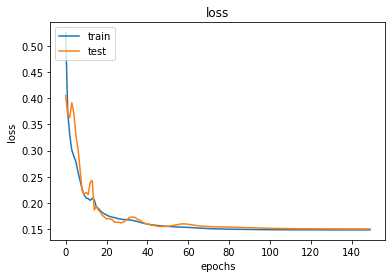

In [44]:
#%pycache

plt.figure()
plt.plot(history.history["loss"]+history_2.history["loss"]+history_3.history["loss"]+history_4.history["loss"])
plt.plot(history.history["val_loss"]+history_2.history["val_loss"]+history_3.history["val_loss"]+history_4.history["val_loss"])
# plt.plot(history.history["loss"]+history_2.history["loss"])
# plt.plot(history.history["val_loss"]+history_2.history["val_loss"])
#plt.plot(history.history["loss"]+history_2.history["loss"]+history_3.history["loss"]+history_4.history["loss"]+history_5.history["loss"]+history_6.history["loss"]+history_7.history["loss"]+history_8.history["loss"]+history_9.history["loss"]+history_10.history["loss"])
#plt.plot(history.history["val_loss"]+history_2.history["val_loss"]+history_3.history["val_loss"]+history_4.history["val_loss"]+history_5.history["val_loss"]+history_6.history["val_loss"]+history_7.history["val_loss"]+history_8.history["val_loss"]+history_9.history["val_loss"]+history_10.history["val_loss"])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

# 20,000 param
## 25 epochs :  41 min

# 12 000 param
## 25 epochs: 30 min

## 10,785 params:
### 25 epochs : 56 min
### 15 epochs : 34 min
</br>

## 31 000
### **20 epochs : 25 min**
 </br>

## 57,009 params
### 20 epochs : 101 min 
</br>

##62,465 pames
### 30 epochs : 78 min
 </br>

## 143,345 params
### 20 epochs : 276 min 
</br>



PARAMS : 7169
Index : 17644
pred : [[58.34847]]
true : [60.5241105]
loss : [[0.03594669]]

Index : 14942
pred : [[257.95657]]
true : [259.54776656]
loss : [[0.00613064]]

Index : 592
pred : [[47.999863]]
true : [38.2575566]
loss : [[0.2546505]]

Index : 17900
pred : [[223.13016]]
true : [180.57621752]
loss : [[0.23565639]]

Index : 6361
pred : [[91.24382]]
true : [117.41448158]
loss : [[0.22289126]]

Index : 5665
pred : [[16.246624]]
true : [18.01713503]
loss : [[0.09826818]]

Index : 17498
pred : [[6.089626]]
true : [5.90924273]
loss : [[0.03052559]]

Index : 1477
pred : [[119.41137]]
true : [105.75301842]
loss : [[0.1291533]]

Index : 5875
pred : [[7.054307]]
true : [9.59282087]
loss : [[0.26462642]]

Index : 9689
pred : [[4.7076225]]
true : [4.92278176]
loss : [[0.04370684]]

Index : 6775
pred : [[45.13923]]
true : [43.55394061]
loss : [[0.03639827]]

Index : 11815
pred : [[38.972775]]
true : [40.49169209]
loss : [[0.03751183]]

Index : 16154
pred : [[57.28927]]
true : [54.97933395]

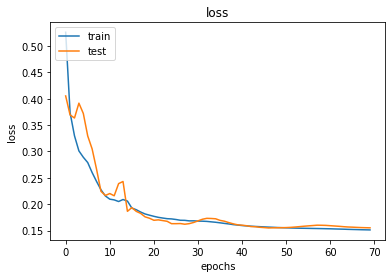

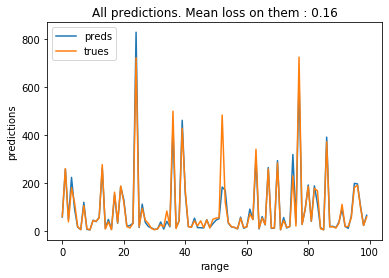

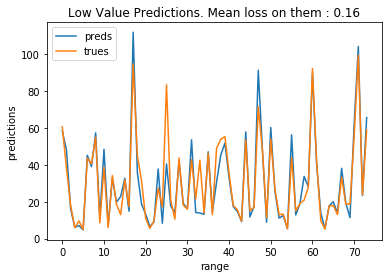

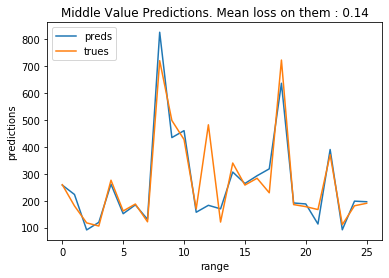

<Figure size 432x288 with 0 Axes>

In [45]:
#%pycache

t5= time.clock()
nb_final_epochs_for_mean = 5
print(f'PARAMS : {full_model.count_params()}')
name = f'{name_test}_{full_model.count_params()}_param'
save = True

nb_predictions = 100
max_val_loss=0.7



model = full_model
X_val_list = [X_val_nn_norm, X_val_hw_param_norm]
history = history

#model = full_model
#X_list = [X_val_hw_param_norm, X_val_nn_norm]

save_model(path=path_entire_model, model= model, history=history, X_list=X_val_list, y=y_val, std=std, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save)

#savetxt(f'{path_entire_model}/{name}/std.csv', std, delimiter=',')


t6= time.clock()


In [39]:
%pycache
print(f'Total time : {(t6-t5)/60} min')

UsageError: Line magic function `%pycache` not found.


In [40]:
#%pycache
checkpoint_path = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/with_inversed_hw/model_1_plus_12161_param_0.131_error/model_1_plus_12161_param"


full_model.load_weights(checkpoint_path)
#results = full_model.evaluate(test_dataset_norm)

# Test size dataset - More data?

In [41]:

#%pycache
path_test_dataset = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/size_dataset/test_size_dataset_4"

print(f'PARAMS : {full_model.count_params()}')
nb_final_epochs_for_mean = 5
save = True
nb_predictions = 100
max_val_loss=50
X_val_list = [X_val_nn_norm, X_val_hw_param_norm]


full_epochs = 25
test_performances = {}
#percents = [0.97]
percents = [0.25, 0.50, 0.75, 0.85, 0.90, 1]
mini_batches_list = l = [int(x * nb_training_batches) for x in percents]

for i, mini_batches in enumerate(mini_batches_list):
    print()
    full_model.set_weights(Wsave)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches,
    decay_rate=0.95)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    train_dataset_percent_norm =train_dataset_norm.take(mini_batches)
    t4= time.clock()
    full_model.compile(optimizer=optimizer, loss=loss)
    
    history = full_model.fit(train_dataset_percent_norm,
            validation_data=(test_dataset_norm),
            epochs=full_epochs,
            verbose=1,
    )

    t5= time.clock()
    print(f'Mini_batch percent: {percents[i]} Training Full Model for {full_epochs} epochs : {(t5-t4)/60} min')
    name = f'percent_{percents[i]}'
    test_performances[percents[i]] =  np.mean((history.history["val_loss"][-nb_final_epochs_for_mean:]))

    save_model(path=path_test_dataset, model= full_model, history=history, X_list=X_val_list, y=y_val, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save)



PARAMS : 12161


NameError: name 'X_val_nn_norm' is not defined

In [42]:
test_performances_save = {0.25: 0.2629273136456808,
 0.5: 0.23724876874023018,
 0.75: 0.21560097336769105,
 0.85: 0.19926969276534187,
 0.87: 0.18293529417779708,
 0.9: 0.17390226572752,
 0.95: 0.1793243298927943,
 0.97: 0.18094,
 1: 0.1743503441413244}

In [43]:
n01498041
find . -type f -iname \*.jpeg -delete
find ./ -type f -name '*.tar' -execdir tar -xvf --one-top-level  \;


find . -maxdepth 1 -type f -name "*n0." -delete
-execdir tar -xvzf {} \;

find . -name "*.tar" -execdir tar --one-top-level -xvf {} \;

--strip-components=1 -zxvf wordpress.tgz

python imagenet_to_gcs.py --raw_data_dir=/data/train --gcs_upload=false --local_scratch_dir="imagenet"


# good!

find . -type f -name "*.tar" -execdir sh -c '
   dirn="${1%.tar}"         # desired directory name
   mkdir -- "$dirn"            # creating a directory
   cd -- "$dirn" &&
   tar -xvf ../"$1"           # extracting to it
' find-sh {} \;

SyntaxError: invalid syntax (<ipython-input-43-0e26ac4791cc>, line 2)

In [44]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_input (InputLayer)       [(None, 37, 7)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 37, 128)      1920        conv1d_input[0][0]               
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 12)]         0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 37, 32)       8224        conv1d[0][0]                     
______________________________________________________________________________________________

In [45]:

plt.figure()
lists = sorted(test_performances.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)

plt.title('Influence size train dataset')
plt.ylabel('Mean error on last epochs')
plt.xlabel('Percent train dataset')
plt.legend(['test'], loc='upper left')

NameError: name 'test_performances' is not defined

In [46]:
!conda list

# packages in environment at /Users/roxanefischer/miniconda3/envs/has:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                       mkl  
absl-py                   0.9.0                    py36_0  
appnope                   0.1.0            py36hf537a9a_0  
asgiref                   3.2.7                    pypi_0    pypi
astor                     0.8.1                    pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
attrs                     19.3.0                     py_0  
backcall                  0.1.0                    py36_0  
blas                      1.0                         mkl  
bleach                    3.1.4                      py_0  
boto3                     1.13.14                  pypi_0    pypi
botocore                  1.16.14                  pypi_0    pypi
c-ares                    1.15.0            h1de35cc_1001  
ca-certificates           2020.1.1                